# Introduction to numerical robotics

This notebook is a general introduction to Pinocchio. It shows how to manipulate the geometry model of a robot manipulator: set the configuration, compute the position of the end effector, check for collisions or the distance to an obstacle. The main idea is to give a brief introduction of the general topic: how to discover and learn a robot movement constrained by the environment, using iterative optimization methods.


## Set up

# Let us load the UR5 robot model, the Pinocchio library, some optimization functions from SciPy and the Matplotlib for plotting:

In [289]:
import pinocchio as pin
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import time
import numpy as np
import scipy
from numpy.linalg import inv,norm,pinv,svd,eig
from scipy.optimize import fmin_bfgs,fmin_slsqp
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles,Target
import matplotlib.pylab as plt

Let's first load the robot model and display it. For this tutorial, a single utility function will load the robot model and create obstacles around it:

In [290]:
robot = load_ur5_with_obstacles(reduced=True)

The next few lines initialize a 3D viewer.

In [291]:
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [292]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

The robot and the red obstacles are encoded in the `robot` object (we will not look in depth at what is inside this object). You can display a new configuration of the robot with `viz.display`. It takes a `numpy.array` of dimension 2 as input:

In [293]:
viz.display(np.array([-1.1, -2.5 ]))


We also set up a target with is visualized as a green dot:

In [294]:
target_pos = np.array([0.5,-0.4])
target = Target(viz,position = target_pos)

The `Target` object is the green dot that the robot should reach. You can change the target position by editing `target.position`, and display the new position with `target.display()`.

## Using the robot model
The robot is originally a 6 degrees-of-freedom (DOF) manipulator. Yet to make the example simple, we will only use its joints 1 and 2. The model has simply be loaded with "frozen" extra joints, which will then not appear in this notebook. Reload the model with `reduced=False` if you want to recover a model with full DOF.

The following function computes the position of the end effector (in 2d):

In [295]:
def endef(q):
     '''Return the 2d position of the end effector.'''
     pin.framesForwardKinematics(robot.model, robot.data, q)
     return robot.data.oMf[-1].translation[[0, 2]]
angle = np.array([0.2,0.3])

print(endef(angle))

[ 0.71538243 -0.26639332]


This function checks if the robot is in collision, and returns `True` if a collision is detected.

In [296]:
def coll(q):
     '''Return True if in collision, false otherwise.'''
     pin.updateGeometryPlacements(robot.model, robot.data, robot.collision_model, robot.collision_data, q)
     return pin.computeCollisions(robot.collision_model, robot.collision_data, False)

angle = np.array([3.14,3.14])

print(coll(angle))

False


The next function computes the distance between the end effector and the target.

Your code:

In [297]:
def dist(q):
     '''Return the distance between the end effector end the target (2d).'''
     end_pose = endef(q)
     target_pose = target_pos
     distance_vector = end_pose - target_pose
     distance = np.linalg.norm(distance_vector)
     return distance


Solution

In [298]:
robot_confuge = np.array([1.2,0.5])
dis = dist(robot_confuge)
print(dis)

0.5665691182467927


## Random search of a valid configuration
The free space is difficult to represent explicitely. We can sample the configuration space until a free configuration is found:

In [299]:
def qrand(check=False):
    '''Return a random configuration. If `check` is True, this configuration is not in collision.'''
    while True:
        joint_1 = np.random.uniform(-2*np.pi, 2*np.pi)
        joint_2 = np.random.uniform(-2*np.pi, 2*np.pi)
        config = np.array([joint_1, joint_2])

        # Perform collision check only if 'check' is True
        if check:
            in_collision = coll(config)
            if not in_collision:
                break
        else:
            break

    return config

The solution if needed:

In [300]:
%do_not_load tp0/generated/simple_path_planning_qrand

UsageError: Line magic function `%do_not_load` not found.


In [301]:
viz.display(qrand(check=True))

In [302]:
print(qrand(check=False))

[4.33072072 1.6922565 ]


Let's now find a valid configuration that is arbitrarily close to the target: sample until dist is small enough and coll is false (you may want to display the random trials inside the loop).

## From a random configuration to the target
Let' s now start from a random configuration. How can we find a path that bring the robot toward the target without touching the obstacles. Any idea?

In [303]:
# Random descent: crawling from one free configuration to the target with random
# steps.
def randomDescent(q0 = None):
     '''
     Make a random walk of 0.1 step toward target
     Return the list of configurations visited
     '''
     q = qrand(check=True) if q0 is None else q0
     hist = [ q.copy() ]
     # DO the walk
     return hist

And solution if needed

In [304]:
%do_not_load tp0/generated/simple_path_planning_random_descent

UsageError: Line magic function `%do_not_load` not found.


In [305]:
randomDescent()

[array([3.1242072 , 5.12724721])]

## Configuration space
Let's try to have a better look of the configuration space. In this case, it is easy, as it is dimension 2: we can sample it exhaustively and plot it in 2D. For that, let's introduce another function to compute the distance to collision:

In [306]:
def collisionDistance(q):
     '''Return the minimal distance between robot and environment. '''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     if pin.computeCollisions(robot.collision_model,robot.collision_data,False):
         return 0.0
     idx = pin.computeDistances(robot.collision_model,robot.collision_data)
     return robot.collision_data.distanceResults[idx].min_distance

Now, let's sample the configuration space and plot the distance-to-target and the distance-to-obstacle field (I put 500 samples to spare your CPU, but you need at least 10x more for obtaining a good picture).

In [307]:
def sampleSpace(nbSamples=500):
     '''
     Sample nbSamples configurations and store them in two lists depending
     if the configuration is in free space (hfree) or in collision (hcol), along
     with the distance to the target and the distance to the obstacles.
     '''
     hcol = []
     hfree = []
     for i in range(nbSamples):
          q = qrand(False)

          if not coll(q):
               hfree.append( list(q.flat) + [ dist(q), collisionDistance(q) ])
          else:
               hcol.append(  list(q.flat) + [ dist(q), 1e-5 ])
     return hcol,hfree

def plotConfigurationSpace(hcol,hfree,markerSize=20):
     '''
     Plot 2 "scatter" plots: the first one plot the distance to the target for 
     each configuration, the second plots the distance to the obstacles (axis q1,q2, 
     distance in the color space).
     '''
     htotal = hcol + hfree
     h=np.array(htotal)
     plt.subplot(2,1,1)
     plt.scatter(h[:,0],h[:,1],c=h[:,2],s=markerSize,lw=0)
     plt.title("Distance to the target")
     plt.colorbar()
     plt.subplot(2,1,2)
     plt.scatter(h[:,0],h[:,1],c=h[:,3],s=markerSize,lw=0)
     plt.title("Distance to the obstacles")
     plt.colorbar()

[ 2.28825098e+00 -2.54663487e+00  4.15864005e-01  1.00000000e-05]


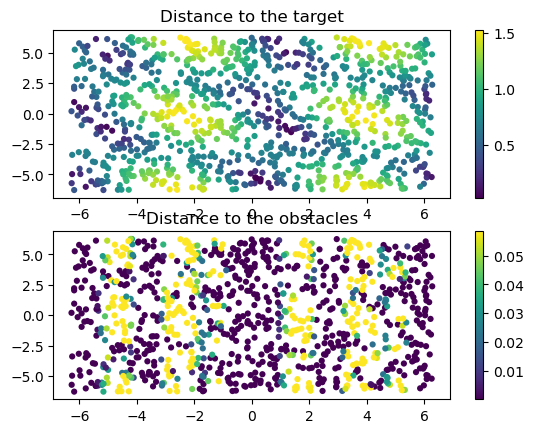

In [308]:
hcol,hfree = sampleSpace(1000)
htotal = hcol + hfree
h=np.array(htotal)
print(h[0])
plotConfigurationSpace(hcol,hfree)



You can try to match your representation of the free space of the robot with this plot. 
As an example, you can display on this plot a feasible trajectory discover by random walk from an init position.

In [309]:

traj = np.array(hfree)
qinit = np.array([-1.1, -2.5 ])
coll(qinit)


False

Here is a solution:

In [310]:
target_rows = np.array([row for row in h if abs(row[2]) <= 0.1])
for i in range(len(target_rows)):
    target_config  = []
    if target_rows[i,3] != 1e-5:
        target_config.append(target_rows[i])
target_config_final = min(target_config) 
print(target_config_final)

[-5.04869817 -1.08848394  0.06440856  0.05052638]


In [311]:
start_config = np.copy(qinit)
goal_config = np.copy(target_config_final[:2])
print(goal_config)
print(start_config)

[-5.04869817 -1.08848394]
[-1.1 -2.5]


In [312]:
def find_trajectory(start, goal, dataset):
    inital_point = np.copy(start)
    goal_configuration = np.copy(goal[:2])
    config = inital_point
    traject = [np.copy(config)]  # Initialize trajectory with the start point

    for _ in range(1000):
        gradient = goal_configuration - config
        norm = np.linalg.norm(gradient)
        print("iteration time", _)
        if norm <= 0.01:  # Avoid division by zero
            break
        
        gradient /= norm  # Normalize the gradient
        step = gradient * 0.02
        config += step

        # Optional: Collision check
        if coll(config): 
        #    ... handle collision ...
            closest_viapoint= closest_point(config,dataset)
            config = closest_viapoint[:2]

        traject.append(np.copy(config))  # Append a copy of config

        if np.linalg.norm(config - goal_configuration) < 0.05:  # Check if goal is reached
            break

    return traject

def closest_point(viapoint, dataset):
    # Extracting the configuration data (assuming the first two columns)
    configu_data = dataset[:,:2]

    # Calculate distances from viapoint to each point in configu_data
    dist_frame = [distance(viapoint, point) for point in configu_data]

    # Find the index of the minimum distance
    min_dist_index = dist_frame.index(min(dist_frame))
    configu_closest=configu_data[min_dist_index]
    return  configu_closest


def distance (viapoint_1, viapoint_2):
     
     distance_vector = viapoint_1 - viapoint_2
     distance = np.linalg.norm(distance_vector)
     
     return distance
    

In [313]:
data = np.array(hfree)
traject = find_trajectory(start_config,goal_config,data)
tarjec_matrix = np.array(traject)


iteration time 0
iteration time 1
iteration time 2
iteration time 3
iteration time 4
iteration time 5
iteration time 6
iteration time 7
iteration time 8
iteration time 9
iteration time 10
iteration time 11
iteration time 12
iteration time 13
iteration time 14
iteration time 15
iteration time 16
iteration time 17
iteration time 18
iteration time 19
iteration time 20
iteration time 21
iteration time 22
iteration time 23
iteration time 24
iteration time 25
iteration time 26
iteration time 27
iteration time 28
iteration time 29
iteration time 30
iteration time 31
iteration time 32
iteration time 33
iteration time 34
iteration time 35
iteration time 36
iteration time 37
iteration time 38
iteration time 39
iteration time 40
iteration time 41
iteration time 42
iteration time 43
iteration time 44
iteration time 45
iteration time 46
iteration time 47
iteration time 48
iteration time 49
iteration time 50
iteration time 51
iteration time 52
iteration time 53
iteration time 54
iteration time 55
it

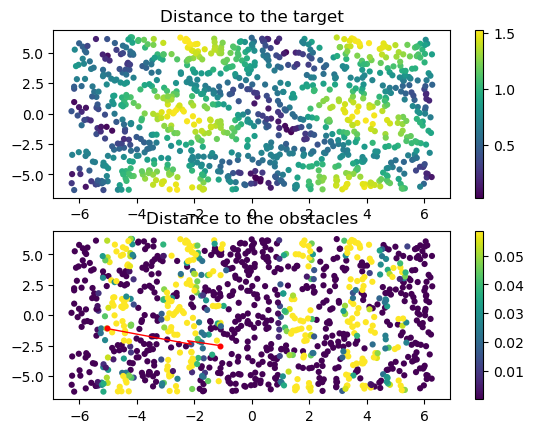

In [314]:
# Add yourr traj to the plot, be carefull !
plotConfigurationSpace(hcol,hfree)
plt.plot(tarjec_matrix[:, 0], tarjec_matrix[:, 1],'r', lw=1)

plt.scatter(target_config_final[0],target_config_final[1],color = 'r',s=11)

plt.scatter(qinit[0], qinit[1], color='r', label='Target', s=11)


## Optimize the distance under non-collision constraint
Finally, let's use one of the optimizers from SciPy to search for a robot configuration that minimizes the distance to the target, under the constraint that the distance to collision is positive.
For that, we define a *cost function* $cost: \mathcal{C} \to \mathbb{R}$ (taking the robot configuration and returning a scalar) and a constraint function (taking again the robot configuration and returning a scalar or a vector of scalar that should be positive). We additionally use the "callback" functionnality of the solver to render the robot configuration corresponding to the current value of the decision variable inside the solver algorithm.
We use the "SLSQP" solver from SciPy, which implements a "sequential quadratic program" algorithm and accepts constraints.


In [315]:
print(target_pos)
Diff= endef(qinit) -target_pos
Diff= endef(qinit) -target_pos
R = np.eye(np.array([Diff]).shape[1])
print(R)

[ 0.5 -0.4]
[[1. 0.]
 [0. 1.]]


In [346]:
def constraint(q):
     ineq_cons = {'type': 'ineq',
             'fun' : lambda q: np.array(collisionDistance(q))}

     return ineq_cons
     
def callback_ROBOT(q):
     '''
     At each optimization step, display the robot configuration in gepetto-viewer.
     '''
     viz.display(q)
     time.sleep(1)

def optimize(cost, x0):
     '''
     Optimize from an initial random configuration to discover a collision-free
     configuration as close as possible to the target.
     USE fmin_slsqp, see doc online
     '''
     initial = x0
     bounds = scipy.optimize.Bounds([-2*np.pi, -2*np.pi], [-2*np.pi, -2*np.pi])
     result = scipy.optimize.minimize(initial, method='SLSQP', constraints=[constraint], bounds=bounds,callback=callback)
     return result.x

path = [] # This list will store the path of points visited
def callback(x):
    path.append(np.copy(x))

In [357]:
# Inequality constraint
def cost(q):
    return dist(q)


ineq_cons = {'type': 'ineq', 'fun': lambda x: np.array(collisionDistance(x))}



# Path storage
path_1 = []
# Callback function
def callback_1(x):
    path_1.append(np.copy(x))

# Initial configuration of the robot
qinit = qinit  # Replace with your initial values
print(qinit)

# Bounds for the robot's configuration
bounds_robot = scipy.optimize.Bounds([-2*np.pi, -2*np.pi], [2*np.pi, 2*np.pi])

# Perform the optimization
result = scipy.optimize.minimize(cost, qinit, method='SLSQP', 
                                 constraints=[ineq_cons], options={'ftol': 1e-3, 'disp': True}, 
                                 bounds=bounds_robot, callback=callback_1)

# Output
print("Optimized configuration:", result.x)

for point in path_1:
    print(point)


path = np.array(path_1)
print(path.shape)


[-1.  -2.5]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006023964393599168
            Iterations: 13
            Function evaluations: 48
            Gradient evaluations: 13
Optimized configuration: [ 0.22393379 -5.38565357]
[-0.93214163 -2.8380581 ]
[-0.84403283 -4.75341899]
[-0.57850999 -4.2961475 ]
[ 0.07284684 -4.82767271]
[ 0.54363209 -5.86740702]
[ 0.1697301  -5.75850984]
[ 0.18978576 -5.37197946]
[ 0.20536147 -5.20087913]
[ 0.4236193  -5.64764457]
[ 0.2463492  -5.44162069]
[ 0.21431527 -5.39375313]
[ 0.21697693 -5.37389596]
[ 0.22505227 -5.38101517]
(13, 2)


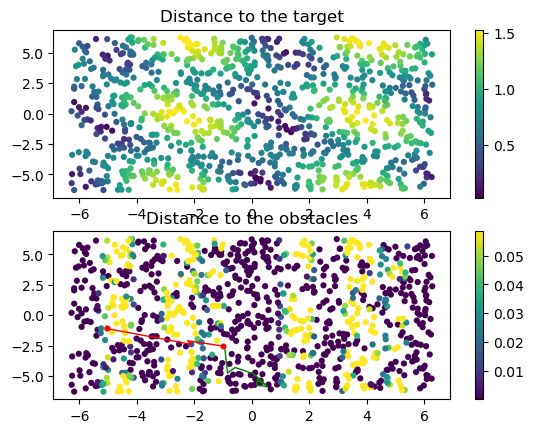

In [358]:
# Add yourr traj to the plot, be carefull !
plotConfigurationSpace(hcol,hfree)
plt.plot(tarjec_matrix[:, 0], tarjec_matrix[:, 1],'r', lw=1)
plt.plot(path[:, 0], path[:, 1],'g', lw=1)
plt.scatter(target_config_final[0],target_config_final[1],color = 'r',s=11)

plt.scatter(qinit[0], qinit[1], color='r', label='Target', s=11)

Here is a valid solution:

In [318]:
%do_not_load tp0/generated/simple_path_planning_optim

UsageError: Line magic function `%do_not_load` not found.


Look at the output of the solver. It always returns a variable value, but sometimes the algorithm fails being traped in an unfeasible region. Most of the time, the solver converges to a local minimum where the final distance to the target is nonzero

Now you can write a planner that try to optimize and retry until a valid solition is found!

In [319]:
# Your solution

And the solution if you need it:

In [341]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

In [351]:


for i in range(len(path)):
    callback_ROBOT(path[i])
